In [80]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple
import os

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [52]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = ['pre_industrial', 'co2_2x']
co2_vals = [1, 2]
n_exp = len(exp_name)
ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], 'output.nc')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [5]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)
ds['ZREFHT'] = cesm.load.load_z2m(invariant_data_path, var_reindex_like=ds.PS)

In [6]:
p_ft = 300 * 100
ds['P'] = cesm.get_pressure(ds.PS, ds.P0.isel(co2=0), ds.hyam.isel(co2=0), ds.hybm.isel(co2=0))
# ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
#                                        np.atleast_1d(p_ft)).load()
# ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
#                                        np.atleast_1d(p_ft)).load()
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['QREFHT'] = ds.Q.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.P.isel(lev=-1)

In [7]:
# Only include Daily average contribution if using 500hPa pressure level
# ds['T500_zonal_daily_av_resize'] = ds.T500_zonal_daily_av.where(ds.time_max.dt.floor('D') == ds.time.dt.floor('D')).max(
#     dim='time')
# if p_ft != 500 * 100:
#     ds['T500_zonal_daily_av_resize'] = ds['T500_zonal_daily_av_resize'] * 0
#     ds['T500_zonal_daily_av'] = ds['T500_zonal_daily_av'] * 0

## LCL
Compare physical LCL to empirical LCL found by requiring error to dry profile less than threshold.

I consider two empirical methods:
1. Potential temperature deviation from surface exceeds threshold.
2. This plus additional requirement that lapse rate in the model layer is below a threshold.

In [15]:
# Physical from lowest model level
ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.T.isel(lev=-1), ds.Q.isel(lev=-1), ds.P.isel(lev=-1))
ds['z_lcl'] = get_var_at_plev(ds.Z3, ds.P, ds.p_lcl)

In [19]:
def find_lcl_empirical(temp_env, p_env, temp_start=None, p_start=None, temp_pot_thresh=0.5):
    # Find LCL as the lowest pressure level where the deviation between environmental and dry profile is less than a threshold
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    temp_pot_env = potential_temp(temp_env, p_env)
    temp_pot_start = potential_temp(temp_start, p_start)
    mask = (temp_pot_env - temp_pot_start) > temp_pot_thresh
    # Find highest level where deviation between t_env and t_dry is more than threshold. Then go to next highest pressure as LCL
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(temp_env.lev.size)).max(dim='lev') + 1).astype(int)

    # Find level in between model levels where diff of pot temp from the surface is exactly temp_thresh
    # Assume fixed lapse rate in log pressure coords between adjacent model levels
    p_low = np.log10(p_env.isel(lev=lcl_ind))  # use log as better for interpolation - gradient is approx constant
    p_high = np.log10(p_env.isel(lev=lcl_ind - 1))  # further from surface

    temp_pot_low = temp_pot_env.isel(lev=lcl_ind)
    temp_pot_high = temp_pot_env.isel(lev=lcl_ind - 1)
    gradient = (temp_pot_high - temp_pot_low) / (p_high - p_low)
    temp_pot_target = temp_pot_start + temp_pot_thresh
    p_target = p_low + (temp_pot_target - temp_pot_low) / gradient
    p_lcl = 10 ** p_target
    return p_lcl, dry_profile_temp(temp_start, p_start, p_lcl)


def find_lcl_empirical2(temp_env, p_env, z_env, temp_start=None, p_start=None, temp_pot_thresh=2,
                        temp_pot_thresh_lapse=0.5, lapse_thresh=8.5):
    # Find the lowest model layer with lapse rate less than lapse_thresh
    # LCL is the level at which the pot temp drops by 0.5K within this layer
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    temp_pot_env = potential_temp(temp_env, p_env)

    # First mask is pot temp close to surface pot temperature
    temp_pot_start = potential_temp(temp_start, p_start)
    mask_temp = np.abs(temp_pot_env - temp_pot_start) <= temp_pot_thresh

    # Second mask is lapse rate close to dry adiabat
    # lower is so append high value at surface
    lapse = -temp_env.diff(dim='lev', label='lower') / z_env.diff(dim='lev', label='lower') * 1000
    lapse = lapse.reindex_like(temp_env)  # make same shape
    lapse = lapse.fillna(lapse_thresh + 5)  # ensure final value satisfies lapse criteria
    mask_lapse = lapse > lapse_thresh
    mask = (mask_temp & mask_lapse)
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(lapse.lev.size)).min(dim='lev')).astype(int)

    p_low = np.log10(p_env.isel(lev=lcl_ind))  # use log as better for interpolation - gradient is approx constant
    p_high = np.log10(p_env.isel(lev=lcl_ind - 1))  # further from surface

    # print(p_low)
    # print(p_high)
    # print(np.log10(p_env))

    temp_pot_low = temp_pot_env.isel(lev=lcl_ind)
    temp_pot_high = temp_pot_env.isel(lev=lcl_ind - 1)
    gradient = (temp_pot_high - temp_pot_low) / (p_high - p_low)
    temp_pot_target = temp_pot_low + temp_pot_thresh_lapse
    p_target = p_low + (temp_pot_target - temp_pot_low) / gradient
    p_target = p_target.clip(min=p_high)
    p_lcl = 10 ** p_target
    # print(dry_profile_temp(temp_start, p_start, p_lcl))
    # print(lapse.isel(lev=lcl_ind-1))
    return p_lcl, dry_profile_temp(temp_start, p_start, p_lcl)


def get_lnb_lev_ind(temp_env, z_env, p_env, p_max=400 * 100, lapse_thresh=5, lapse_change_thresh=2, n_iter=5):
    """
    LNB must be a pressure lower than p_max.
    LNB is level above which is the first layer with negative lapse rate.
    If lapse rate in level immediately below this deviates from the lapse rate in the level below that or two below that,
    then LNB is moved to a lower level by 1. This process is repeated n_iter times.
    Also require lapse rate in level immediately below LNB to be less than lapse_thresh.
    """
    lapse = -temp_env.diff(dim='lev', label='lower') / z_env.diff(dim='lev', label='lower') * 1000
    lapse = lapse.reindex_like(temp_env)  # make same shape
    lapse = lapse.fillna(lapse_dry * 1000)  # ensure final value satisfies lapse criteria
    lapse = lapse.where(p_env < p_max)
    mask = lapse < 0
    lnb_ind = (mask.where(mask, other=np.nan) * np.arange(lapse.lev.size)).max(dim='lev').astype(int)
    # lnb_ind = np.where(lapse < 0)[0][-1]
    # If lapse rate has very big variation, push LNB closer to surface
    for j in range(n_iter):
        is_large_lapse_diff = lapse.isel(lev=lnb_ind + 2) - lapse.isel(lev=lnb_ind + 1) > lapse_change_thresh
        is_large_lapse_diff = is_large_lapse_diff & (lapse.isel(lev=lnb_ind + 1) < lapse_thresh)
        is_large_lapse_diff2 = lapse.isel(lev=lnb_ind + 3) - lapse.isel(lev=lnb_ind + 1) > lapse_change_thresh
        is_large_lapse_diff2 = is_large_lapse_diff2 & (lapse.isel(lev=lnb_ind + 1) < lapse_thresh)
        is_large_lapse_diff = is_large_lapse_diff | is_large_lapse_diff2
        lnb_ind = lnb_ind + is_large_lapse_diff.astype(int)
    lnb_ind = lnb_ind + 1  # make it up to and including this level
    return lnb_ind


ds['p_lcl_emp'], ds['T_lcl_emp'] = find_lcl_empirical(ds.T, ds.P)
ds['p_lcl_emp2'], ds['T_lcl_emp2'] = find_lcl_empirical2(ds.T, ds.P, ds.Z3)
ds['T_at_lcl_emp'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl_emp)
ds['T_at_lcl_emp2'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl_emp2)
ds['lnb_ind'] = get_lnb_lev_ind(ds.T, ds.Z3, ds.P)

In [21]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

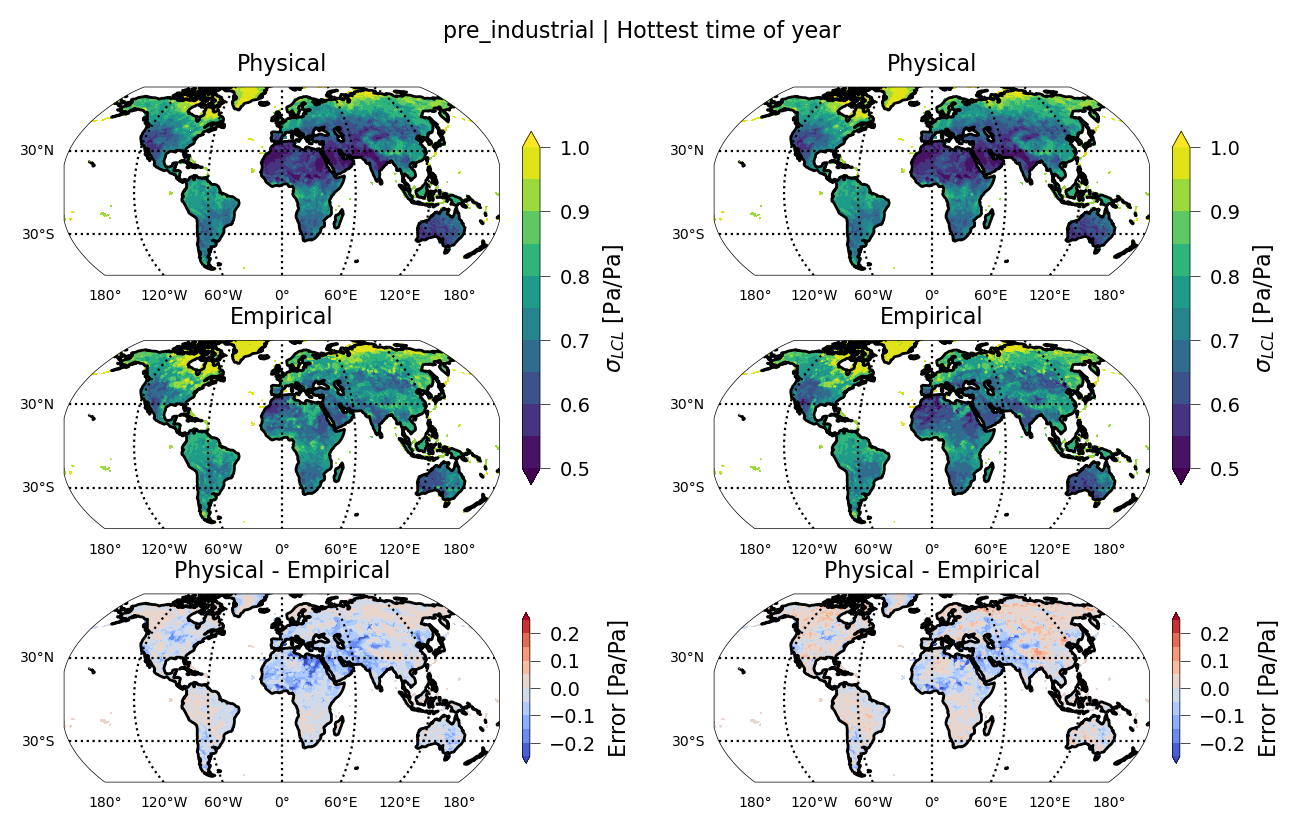

In [22]:
lat_plot_min = -60
lat_plot_max = 80

co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(6.5, 4))
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
for ax_use in ax.flatten():
    initialize_ax_projection(ax_use, lat_min=lat_plot_min, lat_max=lat_plot_max)
# initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
# initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0.5, 1.05, 0.05)
plot_contour_projection(ax[0, 0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1, 0], (ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2, 0], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2, 0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))
fig.colorbar(shrink=0.8, ax=ax[2, 0], label='Error [Pa/Pa]', mappable=im)

plot_contour_projection(ax[0, 1], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1, 1], (ds['p_lcl_emp2'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2, 1], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2, 1], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp2'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))
fig.colorbar(shrink=0.8, ax=ax[2, 1], label='Error [Pa/Pa]', mappable=im)

fig.suptitle(f'{exp_name[co2_ind]} | Hottest time of year', fontsize=8)
for i in range(2):
    ax[0, i].set_title('Physical')
    ax[1, i].set_title('Empirical')
    ax[2, i].set_title('Physical - Empirical')
# isca_tools.savefig(fig)
plt.show()

### Individual Locations
Below, I look at the LCL applied to a specific location, to visualize the difference to the physical LCL.

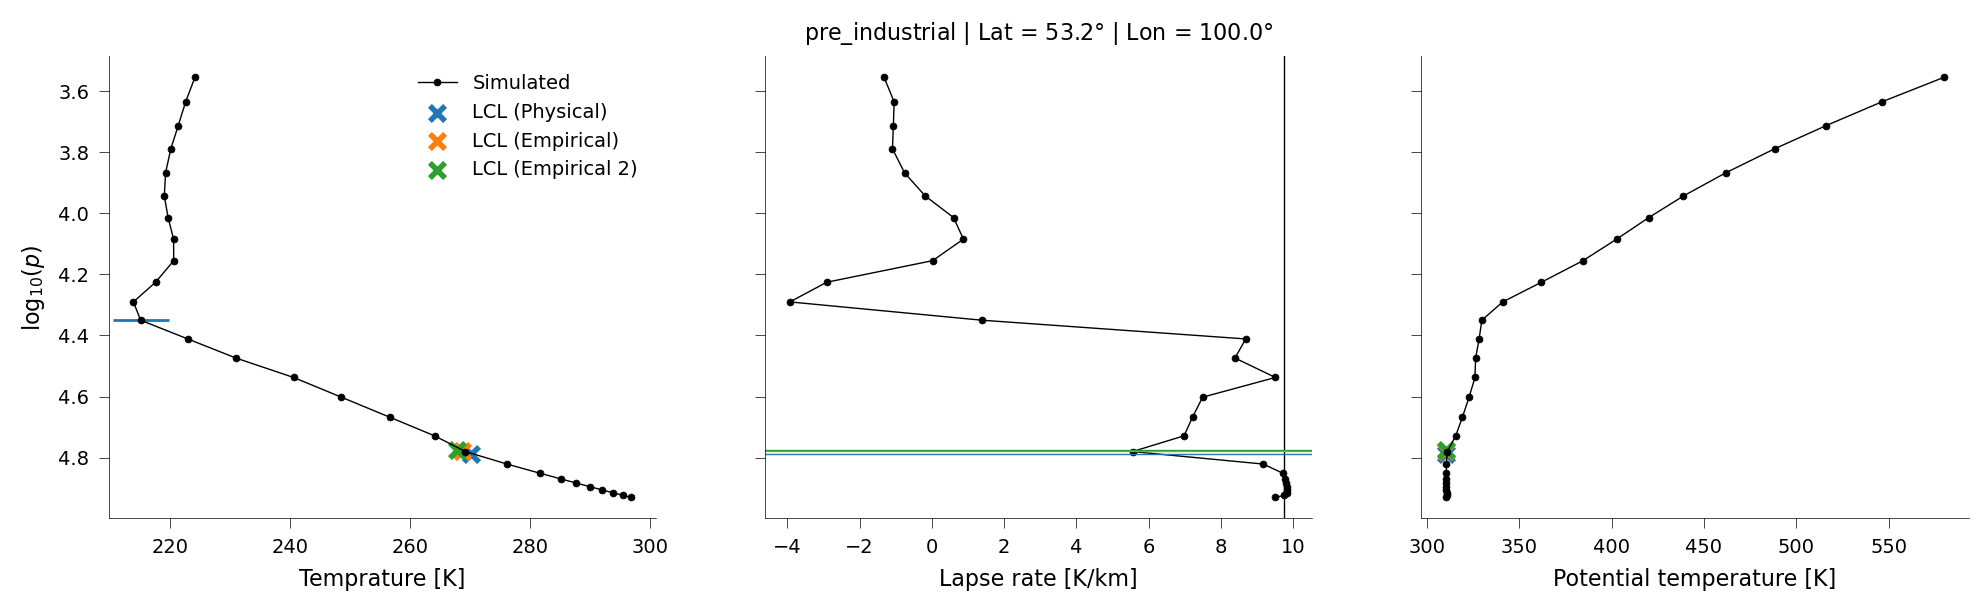

In [23]:
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=320,method='nearest')      # Amazon 1
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=300,method='nearest')    # Amazon 2
# ds_use = ds.isel(co2=1).sel(lat=3, lon=15, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=3, lon=20, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=50, lon=25, method='nearest')        # Europe
ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')  # Canada
# ds_use = ds.isel(co2=1).sel(lat=35, lon=100, method='nearest')        # Tibet
# ds_use = ds.isel(co2=0).sel(lat=30, lon=180, method='nearest')        # Ocean - sanity check
# ds_use = ds.isel(co2=0).sel(lat=18, lon=0,method='nearest')      # Sahara
# ds_use = ds.isel(co2=0).sel(lat=25, lon=50,method='nearest')      # Pursian Gulf
ds_use = ds.isel(co2=0).sel(lat=53, lon=100, method='nearest')  # Canada
ds_use['lapse_rate'] = -ds_use.T.diff(dim='lev', label='upper') / ds_use.Z3.diff(dim='lev', label='upper') * 1000

show_lnb = True
if show_lnb:
    p_max = 30 * 100
else:
    p_max = 300 * 100

fig, ax = plt.subplots(1, 3, sharey=True)
fig_resize(fig, 12)
ax[0].plot(ds_use.T.where(ds_use.P > p_max), np.log10(ds_use.P).where(ds_use.P > p_max), marker='o', color='k',
           label='Simulated')

x_var = ds_use['lapse_rate'].where(ds_use.P.isel(lev=slice(1, 999999)) > p_max)
y_var = np.log10(ds_use.P).isel(lev=slice(1, 999999)).where(ds_use.P.isel(lev=slice(1, 999999)) > p_max)
ax[1].plot(x_var, y_var, marker='o', color='k')
ax[1].axvline(lapse_dry * 1000, color='k')

ds_use['T_pot'] = potential_temp(ds_use.T, ds_use.P)
ax[2].plot(ds_use.T_pot.where(ds_use.P > p_max), np.log10(ds_use.P).where(ds_use.P > p_max), marker='o', color='k',
           label='Simulated')

# Add LCL info
var = find_lcl_empirical2(ds_use.T, ds_use.P, ds_use.Z3)
var = find_lcl_empirical(ds_use.T, ds_use.P)
ax[0].scatter(ds_use.T_lcl, np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0', label='LCL (Physical)')
ax[0].scatter(ds_use.T_lcl_emp, np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2, color='C1', label='LCL (Empirical)')
ax[0].scatter(ds_use.T_lcl_emp2, np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2, color='C2',
              label='LCL (Empirical 2)')
ax[1].axhline(np.log10(ds_use.p_lcl), color='C0')
ax[1].axhline(np.log10(ds_use.p_lcl_emp), color='C1')
ax[1].axhline(np.log10(ds_use.p_lcl_emp2), color='C2')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2,
              color='C1')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2,
              color='C2')

if show_lnb:
    ax[0].scatter(ds_use.T.isel(lev=ds_use.lnb_ind), np.log10(ds_use.P.isel(lev=ds_use.lnb_ind)), marker='_', s=400,
                  lw=1, color='C0')

ax[0].invert_yaxis()
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temprature [K]')
ax[1].set_xlabel('Lapse rate [K/km]')
ax[2].set_xlabel('Potential temperature [K]')
ax[0].legend()
ax[1].set_title(f"{exp_name[int(ds_use.co2) - 1]} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$")
plt.show()

### Size of layer above LCL and below FT level
Next, we want to consider the temperature profile above the LCL but below the LNB level. The minimum size of this layer is approx $p_{LCL}/p_{LNB} = 10^{0.45} = 2.82$, as shown below.

So for an LCL at sea level pressure of 1000hPa, the LNB would be about 350hPa, as shown below.

354.81338923357526


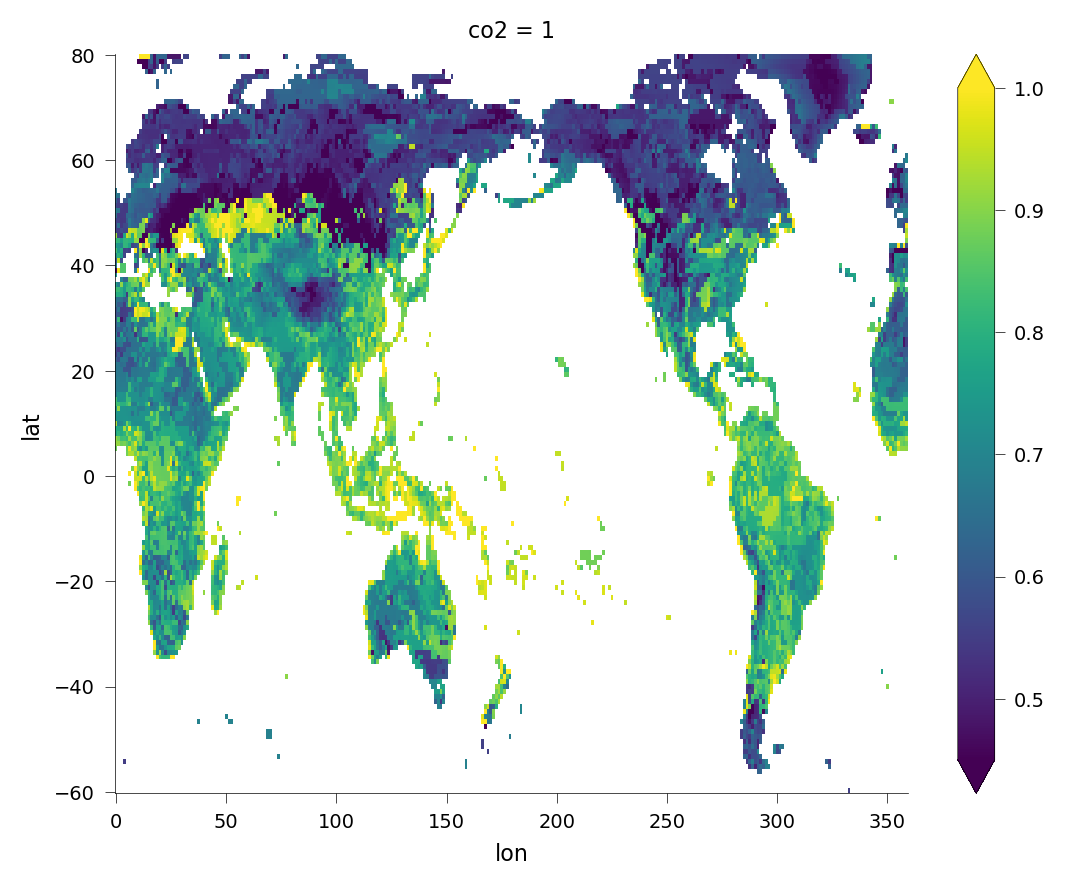

In [24]:
(np.log10(ds.p_lcl_emp2) - np.log10(ds.P.isel(lev=ds.lnb_ind))).isel(co2=0).where(lsm).sel(lat=slice(-60, 80)).plot(
    vmin=0.45, vmax=1)
print(10 ** (np.log10(1000 * 100) - 0.45) / 100)

### Interpolation in region between LCL and LNB
The temperature profiles show pretty uniform lapse rates when plotted against $\log_{10}(p)$, so we want a grid uniform in this space.

I.e. we want to go from $\log_{10}(p_{LCL}) - \log_{10}(p) = 0$ to $0.45$ in equal steps e.g. 0.05.

In the example, we show in blue the profile used above between LCL and LNB for this region. The pressure levels marked as above LNB are not used to characterize the profile because they are in a different (stratospheric) regime.

In [94]:
def interp_nan(x, y):
    # Set all nan values in x based on the two nearest indices that are not nan
    # using linear interpolation
    not_valid = np.isnan(y)
    if not_valid.sum() == 0:
        return y
    else:
        valid_idx = np.where(~not_valid)[0]
        for i in np.where(not_valid)[0]:
            if i < valid_idx[0]:
                # Case: before first valid point
                j1, j2 = valid_idx[0], valid_idx[1]
            elif i > valid_idx[-1]:
                # Case: after last valid point
                j1, j2 = valid_idx[-2], valid_idx[-1]
            else:
                # Case: between valid points
                # nearest valid indices around i
                j2 = valid_idx[valid_idx > i][0]
                j1 = valid_idx[valid_idx < i][-1]
            # Linear interpolation between (x[j1], y[j1]) and (x[j2], y[j2])
            slope = (y[j2] - y[j1]) / (x[j2] - x[j1])
            y[i] = y[j1] + slope * (x[i] - x[j1])
    return y

def interp_var_to_logp(var: xr.DataArray,
                       p: xr.DataArray,
                       var_at_lcl: xr.DataArray,
                       p_lcl: xr.DataArray,
                       lnb_ind: xr.DataArray,
                       d_logp: float = 0.05,
                       logp_max: float = 0.45,
                       extrapolate=True) -> xr.DataArray:
    """Interpolate temperature profiles relative to LCL into z-space.

    Each grid cell has its own model levels and LCL pressure.
    The function interpolates T(z) - T_LCL onto a uniform z grid
    from 0 to zmax above the LCL, in steps of dz.

    Args:
        T (xr.DataArray): Temperature [K], dims ('lat', 'lon', 'lev').
        Z (xr.DataArray): Geopotential height [m], dims ('lat', 'lon', 'lev').
        plev (xr.DataArray): Pressure [hPa], same dims as T and Z.
        p_lcl (xr.DataArray): LCL pressure [hPa], dims ('lat', 'lon').
        dz (float): Vertical spacing [m] for interpolation grid.
        zmax (float): Height above LCL to interpolate up to [m].
        extrapolate: If True, will set values above LNB using linear extrapolation from the 2 nearest points.
            Otherwise, will set to nan

    Returns:
        xr.DataArray: Interpolated T - T_LCL,
            dims ('lat', 'lon', 'z_rel') where z_rel is height above LCL [m].
    """
    small = 1
    T = var.where(p >= p.isel(lev=lnb_ind) - small)
    p = p.where(p >= p.isel(lev=lnb_ind) - small)
    # Define target relative z-grid
    logp_rel = np.arange(0, logp_max + d_logp, d_logp)

    def _interp_onecell(var_prof, p_prof, var_at_lcl, p_lcl):
        # Skip missing
        if np.all(np.isnan(var_prof)):
            return np.full_like(logp_rel, np.nan, dtype=float)

        # Shift to relative z grid
        logp_target = np.log10(p_lcl) - logp_rel
        T_target = np.interp(logp_target, np.log10(p_prof), var_prof)
        if extrapolate:
            T_target = interp_nan(logp_target, T_target)
        return T_target - var_at_lcl

    out = xr.apply_ufunc(
        _interp_onecell,
        T, p, var_at_lcl, p_lcl,
        input_core_dims=[['lev'], ['lev'], [], []],
        output_core_dims=[['logp_rel']],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        kwargs={}
    )

    out = out.assign_coords(logp_rel=logp_rel)
    return out

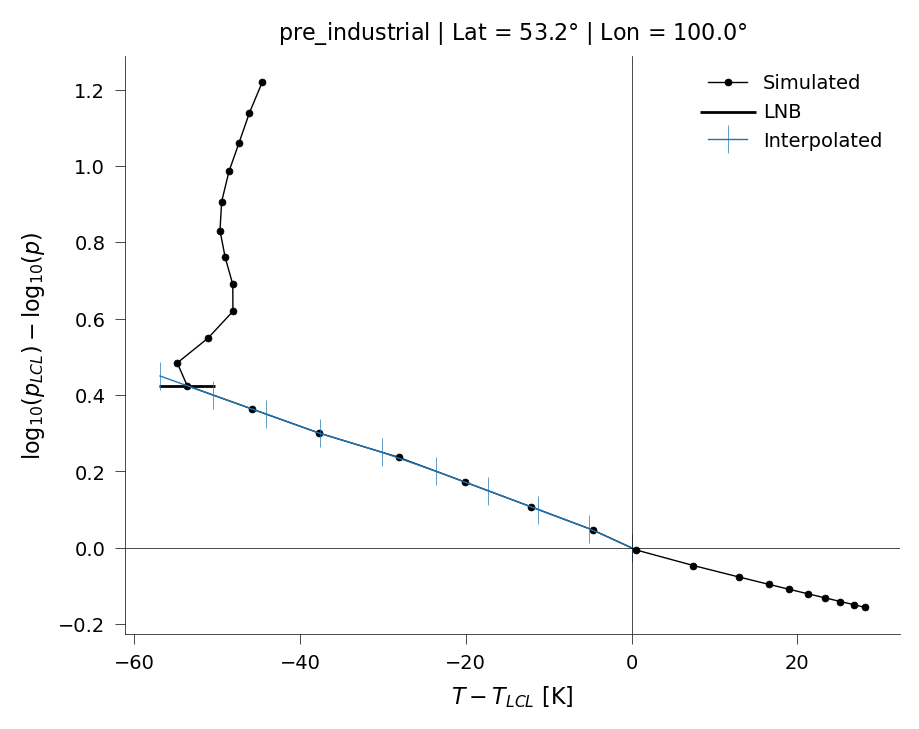

In [95]:
ds_use = ds.isel(co2=0).sel(lat=53, lon=100, method='nearest')  # Canada
# ds_use = ds.isel(co2=0).sel(lat=25, lon=50,method='nearest')        # Persian gulf
var = interp_var_to_logp(ds_use.T, ds_use.P, ds_use.T_at_lcl_emp2, ds_use.p_lcl_emp2, ds_use.lnb_ind)

p_max = 30 * 100

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 5)
ax.plot((ds_use.T - ds_use.T_at_lcl_emp2).where(ds_use.P >= p_max),
        (np.log10(ds_use.p_lcl_emp2) - np.log10(ds_use.P)).where(ds_use.P >= p_max), marker='o', color='k',
        label='Simulated')
ax.scatter(ds_use.T.isel(lev=ds_use.lnb_ind) - ds_use.T_at_lcl_emp2,
           np.log10(ds_use.p_lcl_emp2) - np.log10(ds_use.P.isel(lev=ds_use.lnb_ind)),
           marker='_', s=400, lw=1, color='k', label='LNB')
ax.plot(var, var.logp_rel, marker='|', markersize=10, color='C0', label='Interpolated')
# if var.where(np.isnan(var), drop=True).size > 0:
#     ax.axhline(var.where(np.isnan(var), drop=True).logp_rel, color='C0', lw=ax_linewidth, label='Above LNB')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.legend()
ax.set_xlabel('$T - T_{LCL}$ [K]')
ax.set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
ax.set_title(f"{exp_name[int(ds_use.co2) - 1]} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$")
plt.show()